In [2]:
import pandas as pd 
from functools import reduce
import pickle
import time
from collections import defaultdict
import os
import numpy as np
import matplotlib.pyplot as plt

block_list = [400000]

df = pd.read_pickle('../../pickles/df/400000.pickle')

# New columns for number of input and output transaction ids
df['num_txo'] = df.groupby('id_t')['id_txo_out'].transform('nunique')
df['num_txi'] = df.groupby('id_t')['id_txi'].transform('nunique')

In [3]:
#CHANGE LATER TO QUERY DATABASE INSTEAD

def tx_from_iadr(iadr):
    return set(df['id_t'][df["iadr"] == iadr])

def tx_from_oadr(oadr):
    return set(df['id_t'][df["oadr"] == oadr])

def iadrs_from_tx(id_t):
    return set(df['iadr'][df["id_t"] == id_t])

def oadrs_from_tx(id_t):
    return set(df['oadr'][df["id_t"] == id_t])

def block_from_tx(id_t):
    return set(df['block_no'][df["id_t"] == id_t])

class Addr:
    def __init__(self):
        self.adr = None
        self.sending_tx = set()
        self.receiving_tx = set()
        self.blocks = set()
        self.adr_rec_from = set()
        self.adr_sent_to = set()
        self.iadr_shared = set()
        self.oadr_shared = set()

adrs = []
already_seen_adr = set()

for iadr in set(df.iadr):
    a = Addr()
    a.adr = iadr
    st = tx_from_iadr(iadr)
    rt = tx_from_oadr(iadr)
    a.sending_tx.update(st)
    a.receiving_tx.update(rt)
    for t in st:
        a.adr_sent_to.update(oadrs_from_tx(t))
        shared = iadrs_from_tx(t)
        shared.remove(iadr)
        if shared:
            a.iadr_shared.update(shared)
    for t in rt:
        a.adr_rec_from.update(iadrs_from_tx(t))
        shared = oadrs_from_tx(t)
        shared.remove(iadr)
        if shared:
            a.oadr_shared.update(shared)
    already_seen_adr.add(iadr)
    adrs.append(a)
    
for oadr in set(df.oadr):
    if oadr not in already_seen_adr:
        a = Addr()
        a.adr = oadr
        rt = tx_from_oadr(oadr)
        a.receiving_tx.update(rt)
        for t in rt:
            a.adr_rec_from.update(iadrs_from_tx(t))
            shared = oadrs_from_tx(t)
            shared.remove(oadr)
            if shared:
                a.oadr_shared.update(shared)
        already_seen_adr.add(oadr) 
        adrs.append(a)
        
#WHICH ADDRS IN HAVE TRANSACTED WITH EACH OTHER
edges = []
for adr in adrs:
    a_s=adr.adr_sent_to
    a_r=adr.adr_rec_from
    if(a_s):
        for sadr in a_s:
            edges.append((adr.adr,sadr)) 
    if(a_r):
        for radr in a_r:
            edges.append((radr,adr.adr))

# _num_send_tx = [len(_adr.sending_tx) for _adr in adrs]
# _num_rec_tx = [len(_adr.receiving_tx) for _adr in adrs]

# adr_df = pd.DataFrame(_adrs,columns=['addrs'])

# adr_df['num_send_tx'] = _num_send_tx
# adr_df['num_rec_tx'] = _num_rec_tx
# adr_df['category'] = 'unknown'

#Max Sent
#Min Sent
#Max Rec
#Min_Rec
#Total_Sent
#Total_Rec

In [4]:
# addr input features
addr_input_df = df.groupby('iadr').agg({
    'id_txo_out': 'nunique', #Num unique times paid out
    'oadr':'nunique', #Num of unique out addresses paid out
    'id_t': 'nunique', #Num Txs involved in
    'input_val': ['max', 'min']
})

addr_input_df.columns = ['_'.join(col) for col in addr_input_df.columns]

addr_input_df.rename(columns={
    'id_txo_out_nunique': 'unique_sent', #Num of unique outputs coming from the transaction
    'oadr_nunique': 'unique_sent_adr',
    'id_t_nunique': 'num_send_tx',
    'input_val_max': 'max_sent',
    'input_val_min': 'min_sent'
}, inplace=True)

addr_input_df['total_sent'] = (df['input_val'] / df['num_txo']).groupby(df['iadr']).sum()

# addr input features
addr_out_df = df.groupby('oadr').agg({
    'id_txi': 'nunique', #Num unique times paid in
    'iadr': 'nunique', #Num of unique in addresses paid this address
    'id_t': 'nunique', #Num Txs involved in
    'output_val': ['max', 'min']
})

addr_out_df.columns = ['_'.join(col) for col in addr_out_df.columns]

addr_out_df.rename(columns={
    'id_txi_nunique': 'unique_rec',
    'iadr_nunique': 'unique_rec_adr',
    'id_t_nunique': 'num_receiving_tx',
    'output_val_max': 'max_rec',
    'output_val_min': 'min_rec'
}, inplace=True)

addr_out_df['total_rec'] = (df['output_val'] / df['num_txi']).groupby(df['oadr']).sum()

adr_df = addr_input_df.merge(addr_out_df, how='outer', left_index=True, right_index=True)

adr_df.fillna(0, inplace=True)
#Add column to indicate labelled users
adr_df["category"] = "unknown"

/homes/ac2917/.local/lib/python3.5/site-packages/pandas/core/computation/check.py:17: UserWarning: The installed version of numexpr 2.4.3 is not supported in pandas and will be not be used
The minimum supported version is 2.4.6

  ver=ver, min_ver=_MIN_NUMEXPR_VERSION), UserWarning)


In [5]:
_adrs = [_adr.adr for _adr in adrs]
_num_iadr_shared = [len(_adr.iadr_shared) for _adr in adrs]
_num_oadr_shared = [len(_adr.oadr_shared) for _adr in adrs]

x = set(df.iadr).difference(set(df.oadr))
for i,a in enumerate(_adrs):
    adr_df.loc[a, 'num_iadr_shared'] = _num_iadr_shared[i]
    adr_df.loc[a, 'num_oadr_shared'] = _num_oadr_shared[i]

## Tag addresses

In [6]:
#Dictionary structure - 
#'Address': 'Category'
categories = ['exchanges','gambling','pool']
dic_addrlabels = defaultdict(set)
starttime = time.time() 

for category in categories:
    #for block in range(first_block,last_block+1,1):
    for block in block_list:
        category_df = pd.read_pickle('../../pickles/categories/{}.pickle'.format(category))
        addr = category_df.loc[category_df['last used in block'] == block]['address'].tolist()
        if(len(addr)!=0):
            for a in addr:
                dic_addrlabels[a].add(category)
print("Total time to dict:", time.time()-starttime)

Total time to dict: 2.1054677963256836


In [7]:
for key in dic_addrlabels:
    adr_df.loc[key, 'category'] = dic_addrlabels[key] #label[cat.pop()]  
adr_df = adr_df.dropna(axis=0,how='any')

## Class Imbalance

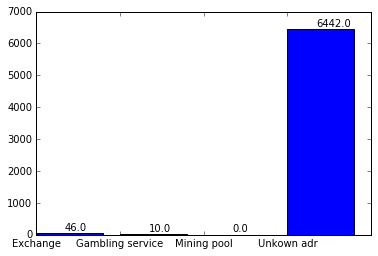

In [8]:
exchanges = np.sum(adr_df["category"] == 'exchanges') # or just sum over column, bc its binary
gambling = np.sum(adr_df["category"] == 'gambling') # or just sum over column, bc its binary
pool = np.sum(adr_df["category"] == 'pool')
unknown = np.sum(adr_df["category"] == 'unknown')

fig, ax = plt.subplots()
exchanges, gambling, pool,unknown = plt.bar((0,1,2,3), (exchanges, gambling, pool,unknown))
gambling.set_facecolor('dimgray')
pool.set_facecolor('lightgray')
ax.set_xticks((0,1,2,3))
for p in (ax.patches):
    ax.annotate(str(p.get_height()), (p.get_x()+0.34, p.get_height() +100), fontsize=10)
ax.set_xticklabels(['Exchange', 'Gambling service', 'Mining pool', 'Unkown adr'])

In [21]:
data_correlation = adr_df.corr(method='spearman')
print("correlation: ")
data_correlation.style.format("{:.2}").background_gradient(cmap=plt.cm.Greens, axis=1)

correlation: 


,max_sent,min_sent,unique_sent_adr,unique_sent,num_send_tx,total_sent,unique_rec,max_rec,min_rec,num_receiving_tx,unique_rec_adr,total_rec,num_iadr_shared,num_oadr_shared
max_sent,1.0,0.99,0.83,0.84,0.87,1.0,-0.56,-0.55,-0.56,-0.63,-0.6,-0.55,0.6,-0.55
min_sent,0.99,1.0,0.83,0.84,0.87,0.99,-0.58,-0.57,-0.57,-0.66,-0.61,-0.57,0.62,-0.57
unique_sent_adr,0.83,0.83,1.0,0.99,0.91,0.83,-0.55,-0.57,-0.58,-0.64,-0.59,-0.57,0.66,-0.55
unique_sent,0.84,0.84,0.99,1.0,0.91,0.84,-0.55,-0.57,-0.58,-0.64,-0.6,-0.58,0.67,-0.55
num_send_tx,0.87,0.87,0.91,0.91,1.0,0.88,-0.66,-0.68,-0.69,-0.74,-0.71,-0.68,0.72,-0.66
total_sent,1.0,0.99,0.83,0.84,0.88,1.0,-0.55,-0.55,-0.55,-0.63,-0.6,-0.55,0.59,-0.55
unique_rec,-0.56,-0.58,-0.55,-0.55,-0.66,-0.55,1.0,0.83,0.82,0.92,0.96,0.83,-0.62,0.86
max_rec,-0.55,-0.57,-0.57,-0.57,-0.68,-0.55,0.83,1.0,1.0,0.91,0.84,1.0,-0.64,0.81
min_rec,-0.56,-0.57,-0.58,-0.58,-0.69,-0.55,0.82,1.0,1.0,0.9,0.83,1.0,-0.64,0.8
num_receiving_tx,-0.63,-0.66,-0.64,-0.64,-0.74,-0.63,0.92,0.91,0.9,1.0,0.92,0.91,-0.73,0.89


In [22]:
data_correlation[(abs(data_correlation) > 0.8) & ( data_correlation != 1.0)].dropna(how="all", axis=(0,1))

/homes/ac2917/.local/lib/python3.5/site-packages/ipykernel_launcher.py:1: FutureWarning: supplying multiple axes to axis is deprecated and will be removed in a future version.
  """Entry point for launching an IPython kernel.


,max_sent,min_sent,unique_sent_adr,unique_sent,num_send_tx,total_sent,unique_rec,max_rec,min_rec,num_receiving_tx,unique_rec_adr,total_rec,num_oadr_shared
max_sent,NaN,0.991750,0.831541,0.838013,0.873385,0.999273,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min_sent,0.991750,NaN,0.831998,0.838581,0.870142,0.989345,NaN,NaN,NaN,NaN,NaN,NaN,NaN
unique_sent_adr,0.831541,0.831998,NaN,0.994739,0.909315,0.832420,NaN,NaN,NaN,NaN,NaN,NaN,NaN
unique_sent,0.838013,0.838581,0.994739,NaN,0.913465,0.838954,NaN,NaN,NaN,NaN,NaN,NaN,NaN
num_send_tx,0.873385,0.870142,0.909315,0.913465,NaN,0.875748,NaN,NaN,NaN,NaN,NaN,NaN,NaN
total_sent,0.999273,0.989345,0.832420,0.838954,0.875748,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
unique_rec,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.828847,0.824356,0.921041,0.957575,0.829095,0.864405
max_rec,NaN,NaN,NaN,NaN,NaN,NaN,0.828847,NaN,0.997583,0.908438,0.838100,0.999325,0.805385
min_rec,NaN,NaN,NaN,NaN,NaN,NaN,0.824356,0.997583,NaN,0.901440,0.834589,0.996618,0.802532
num_receiving_tx,NaN,NaN,NaN,NaN,NaN,NaN,0.921041,0.908438,0.901440,NaN,0.918276,0.910038,0.890628


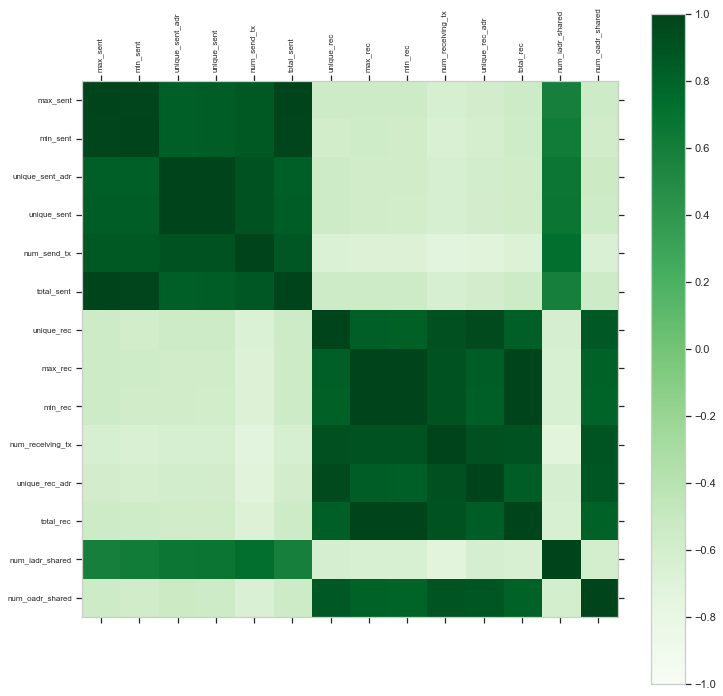

In [23]:
indices = data_correlation.index
fig = plt.figure(figsize = (12,12))
ax = fig.add_subplot(111)
cax = ax.matshow(data_correlation, vmin=-1, vmax=1, cmap=plt.cm.Greens)
fig.colorbar(cax)
ticks = np.arange(0,len(indices),1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
plt.xticks(rotation=90)
ax.set_xticklabels(indices, fontsize=8)
ax.set_yticklabels(indices, fontsize=8)
plt.grid()
plt.savefig("correlation_matrix.pdf")

## Unsupervised

In [11]:
import numpy as np
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
import os

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split
sns.set(style="whitegrid", color_codes=True)
import imblearn

from sklearn import preprocessing
from sklearn import cluster
import scipy as sp
from sklearn.metrics import silhouette_score

In [17]:
#Normalize data
Y = pd.DataFrame(adr_df['category'])
adr_df_x = adr_df.drop(['category'], axis=1)
#scaler = preprocessing.MinMaxScaler()
scaler = preprocessing.StandardScaler()
scaled_x = scaler.fit_transform(adr_df_x)

X = pd.DataFrame(scaled_x, columns=adr_df_x.columns, index=adr_df_x.index)

Explained variation per principal component: [2.33959509e-01 2.01448252e-01 1.83805000e-01 1.60720436e-01
 6.39084521e-02 5.99863447e-02 4.33575427e-02 3.51993583e-02
 1.49345601e-02 2.27234418e-03 1.87804994e-04 1.40060805e-04
 5.96813309e-05 2.06538212e-05]


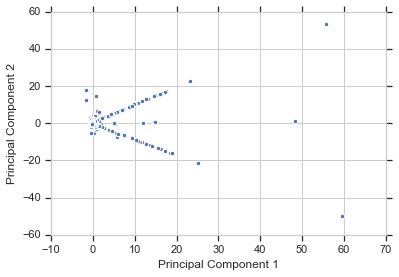

In [18]:
#Principal Component Analysis - DIMENSIONALITY REDUCTION
pca = sklearn.decomposition.PCA()
plot_columns = pca.fit_transform(X)   
#cmap = matplotlib.colors.ListedColormap(colors),
plt.scatter(x=plot_columns[:,0],y=plot_columns[:,1])
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show

print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))


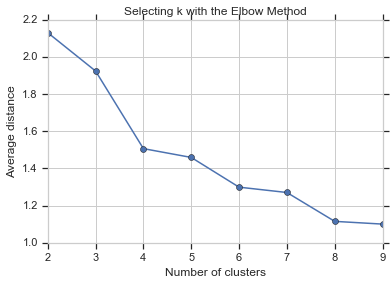

In [19]:
clusters = range(2,10)
meandist=[]
inertias = []
ss = []

for k in clusters:
    model = cluster.KMeans(n_clusters = k)
    model.fit(X)
    meandist.append(sum(np.min(sp.spatial.distance.cdist(X,model.cluster_centers_,'euclidean'),axis=1))/X.shape[0])
    #distorsions.append(model.inertia_) 
    ss.append(silhouette_score(X, model.labels_))

plt.plot(clusters, meandist, '-o')
plt.title('Selecting k with the Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Average distance')

# plt.subplot(1, 2, 2)
# plt.plot(clusters, distorsions, '-o')
# plt.title('Selecting k with the Elbow Method')
# plt.xlabel('Number of clusters')
# plt.ylabel('Model inertia')

plt.show
plt.grid(True)

In [31]:
def pca_and_plot(X_train, y_train):
    pca = sklearn.decomposition.PCA(n_components=2)
    principalComponents = pca.fit_transform(X_train)
    y_df = pd.DataFrame(data = y_train, columns=["category"])
    principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])
    finalDf = pd.concat([principalDf, y_df], axis=1)
    # 2d plot: 
    fig = plt.figure(figsize = (20,20))
    ax = fig.add_subplot(111)
    ax.set_xlabel('Principal Component 1')
    ax.set_ylabel('Principal Component 2')
    ax.set_title('2 component PCA')
    targets = [0,1,2]
    colors = ['gray', '#127161', 'red']
    markers = ['^','o','.']
    for target, color in zip(targets,colors):
        indicesToKeep = finalDf['category'] == target
        ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
                   , finalDf.loc[indicesToKeep, 'principal component 2']
                   , c = color
                   , marker=markers[target]
                   , s = 200)
    ax.legend(targets)
    ax.grid()

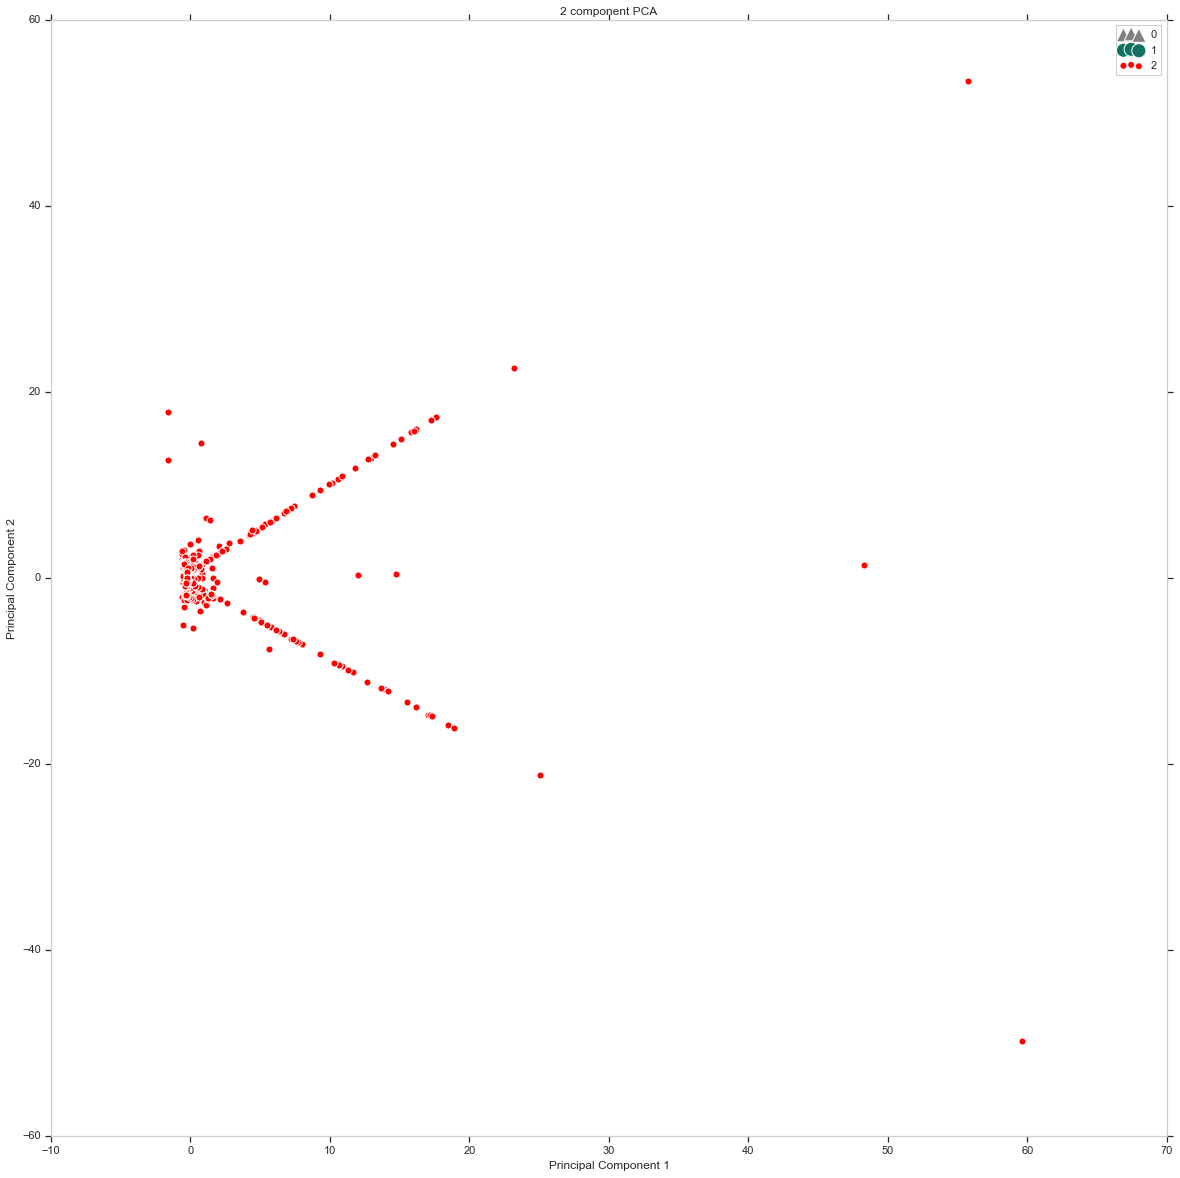

In [32]:
from sklearn.preprocessing import LabelEncoder 
_Y = LabelEncoder().fit_transform(Y.category)
pca_and_plot(X, _Y)

In [28]:
from collections import Counter
Counter(_Y)

Counter({0: 46, 1: 10, 2: 6442})